In [4]:
import sys
import os
import os.path as osp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import math

sys.path.insert(0,'..')
import pyathena as pa

import pandas as pd

from pyathena import LoadSim
from pyathena.util.units import Units

from pyathena.tigress_ncr.hst import Hst
from pyathena.tigress_ncr.load_sim_tigress_ncr import LoadSimTIGRESSNCRAll

models = dict(classic = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.classic.y1.b10.v3.768.xy2048.eps1.e-8/',
              ncr = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8/',
              no_spiral = '/data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3.xy2048.eps1.e-8/')
sa = pa.LoadSimTIGRESSNCRAll(models)

# MODELS
ncr = sa.set_model('ncr')
classic = sa.set_model('classic')
no_spiral = sa.set_model('no_spiral')


ModuleNotFoundError: No module named 'xarray'

In [124]:
# define the domain and the size of the xaxis bins

s = ncr

Lx = s.domain['Lx'][0]
Ly = s.domain['Lx'][1]
Nx = s.domain['Nx'][0]
Ny = s.domain['Nx'][1]
w = Lx/15

# load all the vtk files and calculate sigma_gas for each one 
sigma_gas = []

# get the index of the vtk files
nums = s.nums[0:25] #0-25 for ncr,classic #0:-1 for no spiral
npt = len(nums)

for i in range (npt): # for every snapshot
    ds_data = s.load_vtk(num=s.nums[i])
    ds = ds_data.get_field(['density'])
    ds *= s.u.Msun
    # calculate <sigma> 
    sigma = np.trapz(ds['density'],axis=0)
    sigma_yavg = (np.trapz(sigma,axis=0))/Ny
    sigma_mean = (np.trapz(sigma_yavg,axis=0))/Nx
    # bin sigma in the 15 xaxis bins 
    (sigma_snap, xbin) = np.histogram(ds.x,bins=15,range = (-Lx/2, Lx/2), weights=sigma_yavg)
    sigma_gas.append(sigma_snap/np.average(sigma_snap))#/sigma_mean)

In [125]:
# defining the minimum and maximum value of the GAS surface density 
min_GAS_x =[]
max_GAS_x = []

for i in range (npt):
        max_GAS_x.append(max(sigma_gas[i]))
        min_GAS_x.append(min(sigma_gas[i]))
                        
max_GAS = max(max_GAS_x)   
min_GAS = min(min_GAS_x)

# binning again the values of sigma_GAS at all times in each bin to find the frequency associated with each value
sigma_GAS_x = np.zeros((15,npt))
for i in range (0,npt):
    sigma_GAS_x[:,i] = sigma_gas[i][:]
    
sigma_GASx_binned = []
for i in range (15):
    sigma_GASx_binned.append(np.histogram(sigma_GAS_x[i,:],bins=30,range=(min_GAS,max_GAS)))
    
gas2d = np.zeros((30,15))
for i in range (15):
    gas2d[:,i] = sigma_GASx_binned[i][0]   

[-9.55733333e-01 -8.19200000e-01 -6.82666667e-01 -5.46133333e-01
 -4.09600000e-01 -2.73066667e-01 -1.36533333e-01  1.42108547e-17
  1.36533333e-01  2.73066667e-01  4.09600000e-01  5.46133333e-01
  6.82666667e-01  8.19200000e-01  9.55733333e-01]


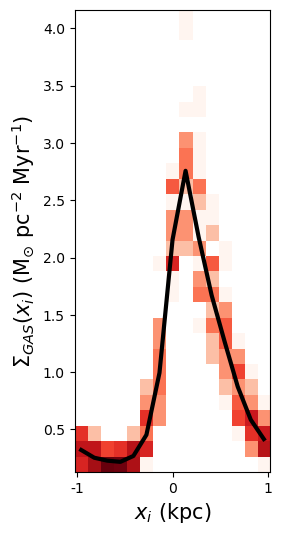

In [126]:
# PLOT AND MEDIAN ##########################################################################################################
# calculate the median values   
import statistics 

sigma_GAS_matrix = np.zeros((15,npt))
sigma_GAS_median = np.zeros(15)

for j in range (npt):
    sigma_GAS_matrix[:,j] = sigma_gas[j][0:15]    
for i in range (15):
    sigma_GAS_median[i] = statistics.median(sigma_GAS_matrix[i,:])
       
# new grid for median plot
xbin_median = np.zeros(15)
for i in range(15):
    xbin_median[i] = xbin[i] + Lx/(15*2)
    
print(xbin_median/1000)

gas2d_norm = np.zeros((30,15))
for i in range (15):
    gas2d_norm[:,i] = gas2d[:,i] #/sigma_GAS_median[i]
    
min_GAS_norm = gas2d_norm.min()
max_GAS_norm = gas2d_norm.max()

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('auto')
im = ax.imshow(gas2d, norm = LogNorm(), origin = 'lower', extent=(-1.024,1.024,min_GAS,max_GAS),  cmap='Reds',aspect =1.2)   #1.5 for ncr and classic, 3.5 for no spiral
#ax.colorbar(fraction=0.06)
#plt.gca().invert_yaxis()
plt.xlabel(r'$x_{i}$ (kpc)',fontsize=15)
plt.ylabel(r'$\Sigma_{GAS}(x_{i})$ (M$_{\odot}$ pc$^{-2}$ Myr$^{-1}$)',fontsize=15)
im = ax.plot(xbin_median/1000,sigma_GAS_median, color='black',linewidth='3')
plt.xticks(ticks=[-1.0,0.0,1.0], labels=[-1,0,1])
plt.show()
fig.set_size_inches(10, 10)

#sigma_GAS_median_nospiral = sigma_GAS_median
#sigma_GAS_median_classic = sigma_GAS_median
sigma_GAS_median_ncr = sigma_GAS_median

In [116]:
## calculate the median values to check if there is significant evolution of the median value with time 
import statistics 

sigma_GAS_matrix = np.zeros((15,npt))
sigma_GAS_median1 = np.zeros(15)
sigma_GAS_median2 = np.zeros(15)
sigma_GAS_median3 = np.zeros(15)
sigma_GAS_median4 = np.zeros(15)
sigma_GAS_median5 = np.zeros(15)

for j in range (npt):
    sigma_GAS_matrix[:,j] = sigma_gas[j][0:15]     
for i in range (15):
    sigma_GAS_median1[i] = statistics.median(sigma_GAS_matrix[i,0:5])
    sigma_GAS_median2[i] = statistics.median(sigma_GAS_matrix[i,5:10])
    sigma_GAS_median3[i] = statistics.median(sigma_GAS_matrix[i,10:15])
    sigma_GAS_median4[i] = statistics.median(sigma_GAS_matrix[i,15:20])
    sigma_GAS_median5[i] = statistics.median(sigma_GAS_matrix[i,20:25])
    

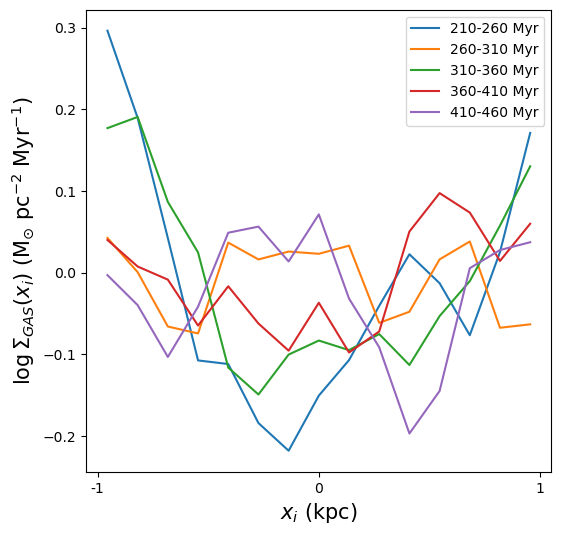

In [117]:
fig = plt.figure(figsize=(6,6))
plt.xlabel(r'$x_{i}$ (kpc)',fontsize=15)
plt.ylabel(r'$\log{\Sigma_{GAS}(x_{i})}$ (M$_{\odot}$ pc$^{-2}$ Myr$^{-1}$)',fontsize=15)
plt.plot(xbin_median/1000,np.log10(sigma_GAS_median1),label='210-260 Myr')
plt.plot(xbin_median/1000,np.log10(sigma_GAS_median2),label='260-310 Myr')
plt.plot(xbin_median/1000,np.log10(sigma_GAS_median3),label='310-360 Myr')
plt.plot(xbin_median/1000,np.log10(sigma_GAS_median4),label='360-410 Myr')
plt.plot(xbin_median/1000,np.log10(sigma_GAS_median5),label='410-460 Myr')
plt.xticks(ticks=[-1.0,0.0,1.0], labels=[-1,0,1])
#plt.ylim(-4,-1)
plt.legend()
plt.show()
fig.set_size_inches(10, 10)


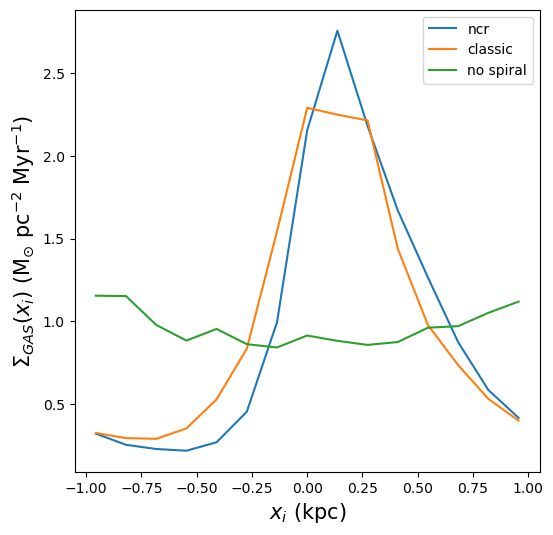

In [133]:
# overplot the medians

plt.figure(figsize=(6,6))
plt.plot(xbin_median/1000,sigma_GAS_median_ncr, label = 'ncr')
plt.plot(xbin_median/1000,sigma_GAS_median_classic, label = 'classic')
plt.plot(xbin_median/1000,sigma_GAS_median_nospiral, label = 'no spiral')
plt.xlabel(r'$x_{i}$ (kpc)',fontsize=15)
plt.ylabel(r'$\Sigma_{GAS}(x_{i})$ (M$_{\odot}$ pc$^{-2}$ Myr$^{-1}$)',fontsize=15)
plt.legend()